In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext watermark
%watermark -ptorch,pandas,numpy -m

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


torch 0.4.1
pandas 0.22.0
numpy 1.15.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [3]:
from pathlib import Path
import itertools
from collections import Counter
from functools import partial, reduce

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from fastai.text import (
    TextDataset, SortishSampler, SortSampler, DataLoader, ModelData, get_rnn_classifier, seq2seq_reg, 
    RNN_Learner, TextModel, to_gpu, LanguageModelLoader, LanguageModelData
)
from fastai.core import T
from fastai.text import accuracy
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
path = Path("../data/cache/lm_douban/")
path.mkdir(parents=True, exist_ok=True)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import And Tokenize Comments and Ratings

In [6]:
UNK = 2
BEG = 1
MIN_FREQ = 200
VOC_SIZE = 10000
EMB_DIM = 300

In [7]:
mapping_orig = joblib.load("../data/mapping.pkl")
df_ratings = pd.read_csv("../data/ratings.csv")
df_ratings.head()

,comment,rating
0,别拿矫揉造作的资产阶级情调麻醉中国人民！,1
1,文青们向往的生活，可是生活中没有了喜怒哀乐，没有了问题与冲突，这种生活也只不过是看上去很美，...,2
2,自由也许在大理，生活确实在别处。,3
3,原来八旬是小四的老公，小彩旗的爹，杨丽萍的妹夫。,3
4,关于大理的蓝光旅游宣传片。,3


### Refit the Vocabulary

In [8]:
cnt = Counter(itertools.chain.from_iterable(df_ratings["comment"]))
cnt.most_common(10)

[('，', 1389819),
 ('的', 1369188),
 ('。', 862231),
 ('是', 621959),
 ('不', 481610),
 ('一', 451352),
 ('了', 450735),
 ('有', 333459),
 ('人', 329015),
 ('看', 293277)]

In [9]:
cnt.most_common(VOC_SIZE)[-10:]

[('寈', 1),
 ('唻', 1),
 ('墬', 1),
 ('筅', 1),
 ('凼', 1),
 ('脇', 1),
 ('🎢', 1),
 ('ث', 1),
 ('إ', 1),
 ('彊', 1)]

In [135]:
mapping = {
    word: token + 3 for token, (word, freq) in enumerate(
        cnt.most_common(VOC_SIZE))
    if freq > MIN_FREQ
}
joblib.dump(mapping, "data/mapping_sent.pkl")
n_toks = len(mapping)
itos = ["pad", "BEG", "UNK"] + [0] *  n_toks
for k, v in mapping.items():
    itos[v] = k
n_toks = len(itos) + 1
len(itos)

FileNotFoundError: [Errno 2] No such file or directory: 'data/mapping_sent.pkl'

In [11]:
itos[-10:]

['靖', '怅', '瞅', '杏', 'っ', '庙', '霜', '抠', '猾', '洼']

In [12]:
voc_diff = set(mapping.keys()) - set(mapping_orig.keys())
sorted([(x, mapping[x]) for x in list(voc_diff)], key=lambda x: x[1], reverse=True)[:20]

[('猾', 3133),
 ('抠', 3132),
 ('瞅', 3127),
 ('怅', 3126),
 ('辫', 3121),
 ('蛊', 3120),
 ('攒', 3118),
 ('喃', 3116),
 ('嘶', 3114),
 ('②', 3109),
 ('咕', 3101),
 ('①', 3098),
 ('姥', 3093),
 ('蜓', 3092),
 ('蜻', 3083),
 ('亢', 3082),
 ('搓', 3075),
 ('淌', 3074),
 ('惘', 3073),
 ('岷', 3065)]

In [14]:
len(voc_diff)

247

### Tokenize

In [15]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=888)
train_idx, test_idx = next(sss.split(df_ratings, df_ratings.rating))
df_train = df_ratings.iloc[train_idx].copy()
df_test = df_ratings.iloc[test_idx].copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=888)
val_idx, test_idx = next(sss.split(df_test, df_test.rating))
df_val = df_test.iloc[val_idx].copy()
df_test = df_test.iloc[test_idx].copy()
del df_ratings

In [16]:
df_test.iloc[0]["comment"],[mapping.get(x, 1) for x in df_test.iloc[0]["comment"]]

('无话可说.', [62, 234, 43, 64, 23])

In [17]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + [mapping.get(x, UNK) for x in row["comment"]]))

In [18]:
assert len(tokens_train) == df_train.shape[0]

### Prepare the embedding matrix

In [19]:
MODEL_PATH = "../data/cache/lm/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.encoder.weight'].shape[1] == EMB_DIM
weights['0.encoder.weight'].shape

torch.Size([3937, 300])

In [20]:
new_matrix = np.zeros((n_toks, EMB_DIM))
hits = 0
for i, w in enumerate(itos):
    if w in mapping_orig:
        new_matrix[i] = weights['0.encoder.weight'][mapping_orig[w]]
        hits += 1
hits, hits *100 / len(itos[3:])

(2885, 92.11366538952745)

In [21]:
weights['0.encoder.weight'] = T(new_matrix)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_matrix))
weights['1.decoder.weight'] = T(np.copy(new_matrix))

## Languange Model

In [22]:
bs = 64
bptt = 50
trn_dl = LanguageModelLoader(np.concatenate(tokens_train), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(tokens_val), bs, bptt)

In [23]:
model_data = LanguageModelData(path, 1, n_toks, trn_dl, val_dl, bs=bs, bptt=bptt)

In [24]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
opt_fn = partial(torch.optim.Adam, betas=(0.8, 0.99))

In [25]:
learner = model_data.get_model(opt_fn, EMB_DIM, 500, 3, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [26]:
learner.model.load_state_dict(weights)

In [27]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=1e-7, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.571147   4.362187   0.248168  



[4.362187013817181, 0.24816782720970543]

In [28]:
learner.save('lm_last_ft')

In [29]:
learner.unfreeze()
learner.clip = 25
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.219186   4.019128   0.284691  



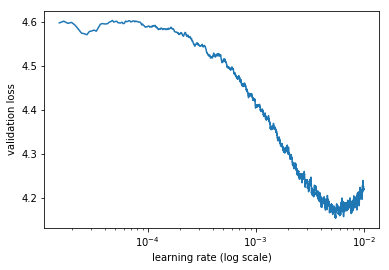

In [30]:
learner.sched.plot()

In [31]:
lr = 3e-3
lrs = lr
learner.fit(lrs, 1, wds=1e-7, use_clr=(20,5), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                     
    0      4.123528   3.915372   0.298677  
    1      4.010968   3.820885   0.309061                     
    2      3.941646   3.760205   0.316861                     
    3      3.896431   3.719881   0.321952                     
    4      3.858556   3.691727   0.325765                     
    5      3.84271    3.666209   0.328942                     
    6      3.811241   3.645512   0.331766                     
    7      3.793308   3.628097   0.334134                     
    8      3.760229   3.613209   0.336333                     
    9      3.759326   3.603918   0.337606                     



[3.6039175098059606, 0.33760618418455124]

In [32]:
learner.save_encoder("lm1_enc")

In [33]:
learner.save("lm1")

In [34]:
del learner

## 3-class Classifier
As in https://zhuanlan.zhihu.com/p/27198713

In [35]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [36]:
df_train.label.value_counts()

2    240094
1    184124
0    104406
Name: label, dtype: int64

In [37]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.label.values)
val_ds = TextDataset(tokens_val, df_val.label.values)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [38]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [39]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [40]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 80%|████████  | 13241/16520 [02:44<00:40, 80.46it/s, loss=3.22] 

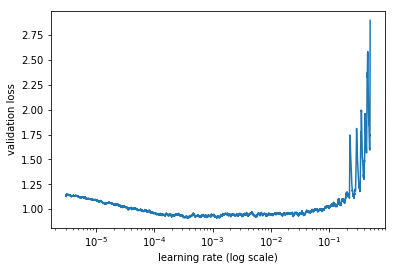

In [41]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [42]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.931715   0.878945   0.578141  


[0.8789454099052362, 0.5781406065558885]

In [43]:
learn.save('clas_0')

In [44]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.902932   0.859624   0.588764  


[0.8596239504865673, 0.5887644147825297]

In [45]:
learn.save('clas_1')

In [46]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      0.875884   0.843668   0.600455  
    1      0.863819   0.825147   0.611822                        
    2      0.842859   0.817996   0.616317                        
    3      0.845006   0.803562   0.624052                        
    4      0.838059   0.802817   0.627236                        
    5      0.834252   0.79209    0.630193                        
    6      0.811338   0.790243   0.63181                         
    7      0.806754   0.788652   0.632293                        
    8      0.804851   0.787352   0.634591                        
    9      0.81854    0.786929   0.635351                        
    10     0.809957   0.789326   0.633609                        
    11     0.816258   0.7824     0.637009                        
    12     0.810927   0.784926   0.636447                        
    13     0.814956   0.783598   0.637338                        


[0.7835975735689567, 0.6373376918187597]

In [47]:
learn.save("clas_full")

### Evaluate

In [50]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(val_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [51]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176208,), (176208,))

In [52]:
pd.Series(ys).value_counts()

2    80031
1    61374
0    34803
dtype: int64

In [53]:
pd.Series(preds).value_counts()

2    92930
1    50913
0    32365
dtype: int64

In [54]:
np.sum(ys==preds) / ys.shape[0]

0.6373376918187597

In [55]:
itos = ["pad", "BEG", "UNK"] + [0] *  n_toks
for k, v in mapping.items():
    itos[v+1] = k

In [56]:
np.where(ys==0)

(array([     8,     15,     22, ..., 176204, 176205, 176207]),)

In [57]:
"".join([itos[x] for x in tokens_val[176204]])

'BEG人一论不再一正乐~。克结错结，托爷'

In [74]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + [mapping.get(x, UNK) for x in texts])).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()

In [75]:
get_prediction("看了快一半了才发现是mini的广告")

array([[ 0.87358,  0.51092, -0.72312]], dtype=float32)

In [76]:
get_prediction("妈蛋，简直太好看了。最后的DJ battle部分，兴奋的我，简直想从座位上站起来一起扭")

array([[-2.46992, -1.8464 ,  1.93631]], dtype=float32)

In [77]:
get_prediction("说实话我没怎么认真看，电影院里的熊孩子太闹腾了，前面的小奶娃还时不时站在老爸腿上蹦迪，观影体验极差，不过小朋友应该挺喜欢的")

array([[-0.17666,  0.92203, -0.29374]], dtype=float32)

In [78]:
get_prediction("这电影太好笑了，说好的高科技人才研制的产品永远在关键时候失灵；特地飞到泰国请来救援人才，大家研究出的方法每次都是先给鲨鱼当诱饵……显然这样的对战坚持不了多久，只能赶紧让鲨鱼输了。")

array([[-1.57963, -0.30202,  0.90608]], dtype=float32)

In [79]:
get_prediction("太接地气了，在三亚煮饺子式的景区海域，冒出来一条大鲨鱼……爽点也很密集，郭达森与李冰冰的CP感不错，编剧果然是老外，中文台词有点尬。")

array([[-1.30785,  0.4874 ,  0.09932]], dtype=float32)

In [80]:
get_prediction("李冰冰的脸真的很紧绷，比鲨鱼的脸还绷。")

array([[-0.91445,  0.74547,  0.37437]], dtype=float32)

In [81]:
get_prediction("太难了。。。")

array([[ 0.39725, -0.2176 ,  0.13541]], dtype=float32)

In [82]:
get_prediction("把我基神写成智障，辣鸡mcu")

array([[ 1.47396, -0.14072, -0.67808]], dtype=float32)

In [83]:
get_prediction("鲨鱼部分还是不错的，尤其是中段第一次出海捕鲨非常刺激，其后急速下滑，三亚那部分拍得是什么鬼。。。爆米花片可以适度的蠢，但人类反派炸鲨和直升机相撞部分简直蠢得太过份了吧？另外充满硬加戏视感的尴尬感情戏把节奏也拖垮了，明明可以更出色，却很遗憾地止步在马马虎虎的水平。6/10")

array([[-1.01065,  0.80483, -2.39897]], dtype=float32)

In [84]:
get_prediction("老冰冰真的很努力！为老冰冰实现了她的好莱坞女主梦鼓掌...")

array([[-1.7034 ,  0.2839 ,  1.22209]], dtype=float32)

In [85]:
get_prediction("结局简直丧出天际！灭霸竟然有内心戏！全程下来美队和钢铁侠也没见上一面，我还以为在世界末日前必然要重修旧好了！")

array([[ 0.31844,  0.34698, -0.12014]], dtype=float32)

In [86]:
get_prediction("太烂了，难看至极。")

array([[ 5.31052, -2.62668, -5.6813 ]], dtype=float32)

In [87]:
get_prediction("看完之后很生气！剧情太差了")

array([[ 1.19661,  0.2399 , -0.79594]], dtype=float32)

In [88]:
get_prediction("关键点都好傻，我知道你要拍续集，我知道未来可以被重写， 但那一拳真的有点傻。")

array([[ 0.74671,  0.57978, -0.20511]], dtype=float32)

In [89]:
get_prediction("好了可以了。再也不看Marvel了。我努力过了。实在是。。啥呀这是。🙄️")

array([[0.2814 , 0.30807, 0.33032]], dtype=float32)

In [90]:
get_prediction("还我电影票14元")

array([[ 1.25546, -0.2495 , -0.03   ]], dtype=float32)

Confusion matrix, without normalization
[[20218  9185  5400]
 [ 8780 28575 24019]
 [ 3367 13153 63511]]


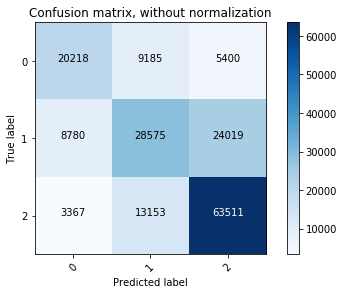

In [91]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.58 0.26 0.16]
 [0.14 0.47 0.39]
 [0.04 0.16 0.79]]


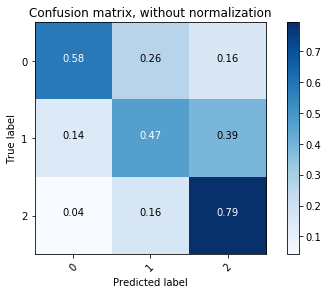

In [92]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [93]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 62%, R 58%, FS 0.60, Support: 34803
Class 1: P 56%, R 47%, FS 0.51, Support: 61374
Class 2: P 68%, R 79%, FS 0.73, Support: 80031


In [94]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [95]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [96]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [97]:
np.sum(ys==preds) / ys.shape[0]

0.6346384123398918

Confusion matrix, without normalization
[[19856  9385  5561]
 [ 8808 28533 24034]
 [ 3294 13298 63440]]


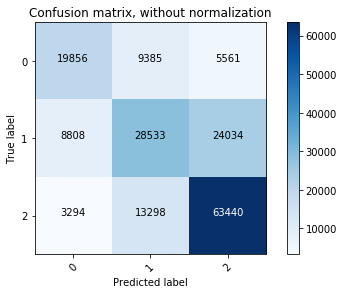

In [98]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.57 0.27 0.16]
 [0.14 0.46 0.39]
 [0.04 0.17 0.79]]


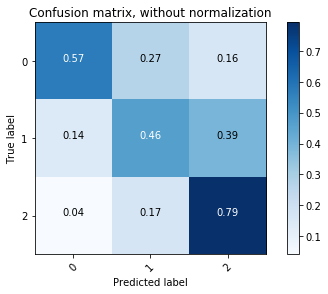

In [99]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [100]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 62%, R 57%, FS 0.59, Support: 34802
Class 1: P 56%, R 46%, FS 0.51, Support: 61375
Class 2: P 68%, R 79%, FS 0.73, Support: 80032


### Smaller Dataset 

In [101]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [102]:
df_train_small = pd.concat([
    df_train[df_train.label==0].sample(15000),
    df_train[df_train.label==1].sample(15000),
    df_train[df_train.label==2].sample(15000)
], axis=0)
df_val_small = pd.concat([
    df_val[df_val.label==0].sample(5000),
    df_val[df_val.label==1].sample(5000),
    df_val[df_val.label==2].sample(5000)
], axis=0)

In [103]:
np.array(df_train_small.index)

array([213557, 405113, 420143, ..., 113128,  26724, 106742])

In [104]:
bs = 64
tokens_train_small = np.array(tokens_train)[np.array(df_train_small.index)]
tokens_val_small = np.array(tokens_val)[np.array(df_val_small.index)]
trn_ds = TextDataset(tokens_train_small, df_train_small.label.values)
val_ds = TextDataset(tokens_val_small, df_val_small.label.values)
trn_samp = SortishSampler(tokens_train_small, key=lambda x: len(tokens_train_small[x]), bs=bs//2)
val_samp = SortSampler(tokens_val_small, key=lambda x: len(tokens_val_small[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [105]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [107]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [108]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 82%|████████▏ | 1149/1407 [00:12<00:02, 94.78it/s, loss=3.38]

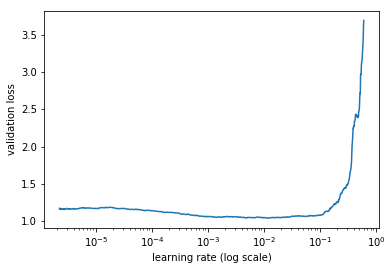

In [109]:
learn.freeze_to(-1)
learn.lr_find(lrs/100)
learn.sched.plot()

In [110]:
lr=2e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.04091    0.951566   0.534133  


[0.951565968767802, 0.5341333333333333]

In [111]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      1.012139   0.930201   0.544533  


[0.9302009292602539, 0.5445333333651224]

In [112]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      1.00208    0.909852   0.557667  
    1      0.988538   0.903172   0.568733                      
    2      0.973335   0.884232   0.580067                      
    3      0.966212   0.874211   0.5854                        
    4      0.937243   0.874692   0.5892                        
    5      0.934662   0.873447   0.588933                      
    6      0.923458   0.864081   0.594867                      
    7      0.922806   0.865775   0.5944                        
    8      0.924494   0.86593    0.594067                      
    9      0.930624   0.861021   0.594667                      
    10     0.925022   0.855482   0.5992                        
    11     0.904549   0.860083   0.598933                      
    12     0.93201    0.861054   0.596667                      
    13     0.902114   0.855718   0.6006                        


[0.8557179355621338, 0.6006]

In [113]:
learn.save("clas_small_full")

In [114]:
learn.model.eval()
preds, ys = [], []
for x, y in val_dl:
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [115]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((15000,), (15000,))

Normalized confusion matrix
[[0.68 0.19 0.13]
 [0.25 0.42 0.33]
 [0.11 0.19 0.7 ]]


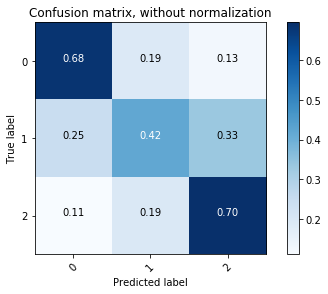

In [116]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [117]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [118]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [119]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [120]:
np.sum(preds==ys) / preds.shape[0]

0.5921717959922592

Normalized confusion matrix
[[0.67 0.2  0.13]
 [0.26 0.41 0.33]
 [0.11 0.19 0.7 ]]


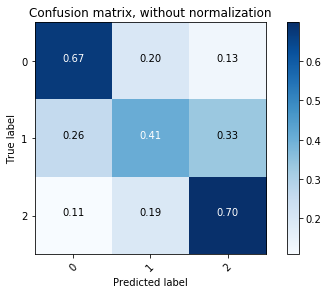

In [121]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [122]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 49%, R 67%, FS 0.57, Support: 34802
Class 1: P 53%, R 41%, FS 0.46, Support: 61375
Class 2: P 69%, R 70%, FS 0.69, Support: 80032


## Regressor

In [123]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.rating.values.astype("float32"))
val_ds = TextDataset(tokens_val, df_val.rating.values.astype("float32"))
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [124]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [125]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 1], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [126]:
class RNN_RegLearner(RNN_Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return lambda x, y: F.mse_loss(x[:, 0], y)

In [127]:
learn = RNN_RegLearner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = []
learn.load_encoder('lm1_enc')

In [128]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

 81%|████████  | 13348/16520 [03:02<00:43, 73.21it/s, loss=1.4]  

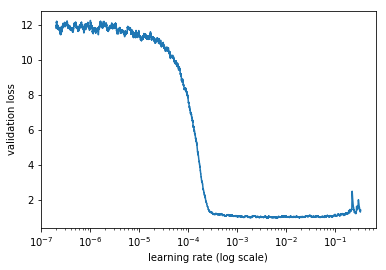

In [129]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [130]:
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_0')

epoch      trn_loss   val_loss                                   
    0      0.968221   0.865725  


In [131]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_1')

epoch      trn_loss   val_loss                                   
    0      0.905225   0.835463  


In [132]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))
learn.save('reg_full')

epoch      trn_loss   val_loss                                   
    0      0.889001   0.810576  
    1      0.89244    0.773509                                   
    2      0.7998     0.752368                                   
    3      0.805316   0.73986                                    
    4      0.77228    0.722108                                   
    5      0.781112   0.716881                                   
    6      0.785651   0.72082                                    
    7      0.768798   0.716898                                   
    8      0.735351   0.715576                                   
    9      0.768486   0.715306                                   
    10     0.773695   0.721079                                   
    11     0.735189   0.699495                                   
    12     0.808614   0.709349                                   
    13     0.749544   0.702017                                   


In [133]:
# Export Model
torch.save(learn.model, path / "sentiment_model.pth")

In [134]:
learn.load('reg_full')

### Evaluation

In [138]:
test_ds = TextDataset(tokens_test, df_test.rating.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [139]:
def get_preds(data_loader):
    learn.model.eval()
    learn.model.reset()         
    preds, ys = [], []
    for x, y in tqdm_notebook(data_loader):   
        preds.append(learn.model(x)[0].cpu().data.numpy()[:, 0])
        ys.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    return ys, preds
ys, preds = get_preds(val_dl)
preds.shape, ys.shape

((176208,), (176208,))

In [140]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [141]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [142]:
np.sum(np.square(preds - ys)) / preds.shape[0]

0.7020173335631753

In [143]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6958915830297149

In [144]:
# Save predictions
df_val.loc[df_val.iloc[list(iter(val_samp))].index, "preds"] = preds
df_val.to_csv(path / "df_val.csv.gz", index=False, compression="gzip")
df_val.head()

,comment,rating,label,preds
0,男主角像卡卡,2,0,3.479422
1,经典改编，还是忠于原著的，一路都很稳。,4,2,4.060974
2,叙事：时间空间的有机结合,5,2,3.754907
3,看街头小混混打外星人挺热闹的，可是前一秒还在抢劫的少年犯，下一秒就变成了拯救世界的大英雄，导...,2,0,2.596663
4,这电影也就一般,3,1,2.412054


In [145]:
np.sum(np.square(df_val.rating.values - df_val.preds.values)) / preds.shape[0]

0.6958915595702729

In [146]:
ys, preds = get_preds(test_dl)
preds.shape, ys.shape

((176209,), (176209,))

In [147]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.7007267883487146

In [148]:
# Save predictions
df_test.loc[df_test.iloc[list(iter(test_samp))].index, "preds"] = preds
df_test.to_csv(path / "df_test.csv.gz", index=False, compression="gzip")
df_test.head()

,comment,rating,label,preds
258461,无话可说.,3,1,2.579908
118491,老师你太可爱,5,2,4.153790
44768,说了好多话，可惜都是陈词滥调、无凭无据。,2,0,2.407399
34630,普巴家用的电脑是苹果。,3,1,3.029899
382761,这才是一部看完之后观众讲不清道不明的电影，主线不明了，支线都快抢过主线的风头了。而且，我也讲...,4,2,3.379535


In [149]:
df_test.sample(20)

,comment,rating,label,preds
630257,柴荣死的时候才39岁，用田丰演那么老气实在太残念了，另外我总觉得赵匡胤怎么眼熟，度了一下发现...,4,2,3.466819
639998,《孤独的生还者》里面4个seal因为不杀平民导致自己死了3个。《报复行动》里一群傻逼mari...,4,2,3.288943
307954,没有周星驰，所有的无厘头都像是跟风而已，找不到精髓，就变成了山寨。,3,1,1.867689
652487,一个通过人性来反映战争的片子，这种反而更能触动人心，二战的时候的压迫与无奈，很多人其实并不想...,3,1,3.790112
125312,我很骄傲自己哪怕是在那些流言蜚语将MJ妖魔化小丑化到极端的时候我都没有怀疑过这个人。,5,2,3.799084
582889,还是牛逼的柳河,5,2,3.829310
65551,一首写实的大海之诗。导演的高明之处在于，并不简单地展示海中的生活，而是有一条儿子的主线。,4,2,3.988124
353104,也就看个热闹，居然还是改编于小说，这得是多烂的一部小说啊……,3,1,2.194700
781775,这里是怎么打架的，锦衣卫里又是怎么打架的,5,2,3.027639
782493,连这个都翻出来了[摊手],3,1,3.011955


In [150]:
np.sum(np.square(df_test.rating.values - df_test.preds.values)) / preds.shape[0]

0.7007267883487144

In [151]:
preds_class = np.round(preds)

Confusion matrix, without normalization
[[ 2493  4296  3798   874    61]
 [ 1249  7297 12153  2546    35]
 [  260  4763 35676 20317   359]
 [   38   724 16212 35438  2237]
 [   19   259  3968 17461  3676]]


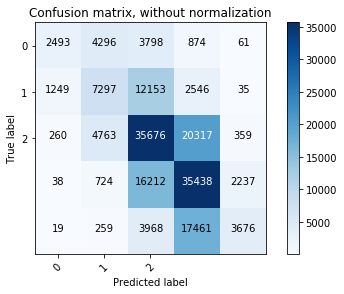

In [152]:
cnf_matrix = confusion_matrix(ys, preds_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

In [153]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds_class)
for i in range(5):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 61%, R 22%, FS 0.32, Support: 11522
Class 1: P 42%, R 31%, FS 0.36, Support: 23280
Class 2: P 50%, R 58%, FS 0.54, Support: 61375
Class 3: P 46%, R 65%, FS 0.54, Support: 54649
Class 4: P 58%, R 14%, FS 0.23, Support: 25383


In [163]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + [mapping.get(x, UNK) for x in texts])).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()[0, 0]

In [164]:
get_prediction("看了快一半了才发现是mini的广告")

2.460428

In [165]:
get_prediction("妈蛋，简直太好看了。最后的DJ battle部分，兴奋的我，简直想从座位上站起来一起扭")

4.7503815

In [166]:
get_prediction("说实话我没怎么认真看，电影院里的熊孩子太闹腾了，前面的小奶娃还时不时站在老爸腿上蹦迪，观影体验极差，不过小朋友应该挺喜欢的")

3.0046263

In [167]:
get_prediction("李冰冰的脸真的很紧绷，比鲨鱼的脸还绷。")

3.259626

In [168]:
get_prediction("太烂了，难看至极。")

0.8791629

In [169]:
get_prediction("还我电影票14元")

2.1875534

In [170]:
get_prediction("好了可以了。再也不看Marvel了。我努力过了。实在是。。啥呀这是。🙄️")

3.228706

In [171]:
get_prediction("把我基神写成智障，辣鸡mcu")

1.9167452